In [8]:
import pandas as pd
import numpy as np
from numpy.random import normal
from numpy.random import uniform
from numpy.random import random
from warnings import catch_warnings
from warnings import simplefilter
from sklearn.gaussian_process import GaussianProcessRegressor
from scipy.stats import norm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
returns=pd.read_csv("asset_class_returns.csv")
returns = pd.DataFrame(returns).set_index("Year")
returns=returns.apply(lambda num : num.str.strip('%'))
for col in returns.columns:
    returns[col]=returns[col].astype(str).astype(float)
cols=returns.columns

Data Exploration - Note: columns are of different lengths due to difference in dataset lengths. My function accounts for this by having a max range of 1995-2019, years in which all data is present for columns used

In [29]:
returns[cols]

,Inflation,US Stock Market,US Large Cap,US Large Cap Value,US Large Cap Growth,US Mid Cap,US Mid Cap Value,US Mid Cap Growth,US Small Cap,US Small Cap Value,...,Corporate Bonds,Long-Term Corporate Bonds,High Yield Corporate Bonds,Short-Term Tax-Exempt,Intermediate-Term Tax-Exempt,Long-Term Tax-Exempt,REIT,Gold,Precious Metals,Commodities
Year,,,,,,,,,,,,,,,,,,,,,
1972,3.41,17.62,18.95,15.32,22.97,8.02,11.94,4.29,8.66,11.15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49.02,NaN,NaN
1973,8.71,-18.18,-16.18,-9.79,-23.09,-24.20,-13.77,-32.96,-32.85,-24.12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72.96,NaN,NaN
1974,12.34,-27.81,-26.93,-21.13,-32.34,-26.34,-19.80,-32.64,-27.59,-21.09,...,NaN,-2.27,NaN,NaN,NaN,NaN,NaN,66.15,NaN,NaN
1975,6.94,37.82,36.95,40.67,33.10,48.69,56.79,41.95,55.13,53.94,...,NaN,9.95,NaN,NaN,NaN,NaN,NaN,-24.80,NaN,NaN
1976,4.86,26.47,24.18,33.32,14.85,36.67,46.79,26.54,45.33,54.78,...,NaN,15.35,NaN,NaN,NaN,NaN,NaN,-4.10,NaN,NaN
1977,6.70,-3.36,-7.84,-3.31,-8.66,1.30,5.24,-2.12,15.67,15.88,...,NaN,4.98,NaN,NaN,NaN,NaN,NaN,22.64,NaN,NaN
1978,9.02,8.45,5.87,6.37,7.11,8.97,9.05,8.80,17.74,19.25,...,NaN,2.05,NaN,2.31,-4.65,5.93,NaN,37.01,NaN,NaN
1979,13.29,24.25,18.05,23.22,17.44,31.48,29.84,33.07,41.02,37.80,...,NaN,-0.77,5.57,4.78,-1.58,-2.97,NaN,126.55,NaN,NaN
1980,12.52,33.15,31.92,31.75,35.59,30.76,17.60,45.25,35.78,25.77,...,NaN,4.66,3.16,5.30,-10.35,-16.00,NaN,15.19,NaN,NaN


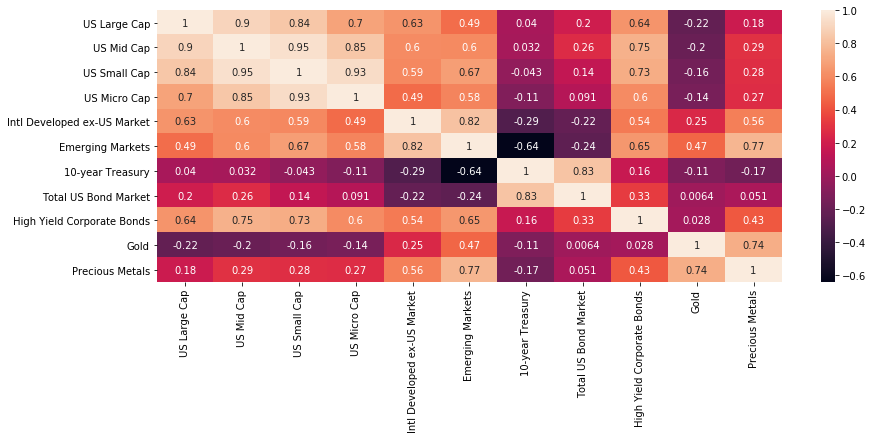

In [31]:
#correlation
plt.figure(figsize=(14, 5))
sns.heatmap(returns[col].corr(),annot=True)

Portfolio Optimization to Backtest - Note: This is purposeful overfitting to show the value of diversification to assets with anti and uncorrelated returns. This can be seen through an optimization of the sharpe ratio.

In [19]:
def backtest(wealth,weights,col, start_date, end_date, data):
    colin=[0]*len(weights)
    port=[0]*len(weights)
    worth=[]
    start=wealth
    cash=returns["Cash"]
    data=data[col].copy()
    data=pd.merge(data,cash,on="Year").dropna()
    data.iloc[(start_date-1995):(end_date-1995)]

    for n in range(len(weights)):
        colin[n] = data.columns.get_loc(col[n])
        port[n]=start*weights[n]

    for n in range (0,len(data)):  #
        for i in range(len(weights)):
            port[i]=port[i]*(1+data.iloc[n,colin[i]]/100)
            
        yr_end = sum(port)   #100/99*(if doing by hand)
        worth.append(yr_end)
        for i in range(len(weights)): port[i] = yr_end * weights[i]
        
    p_rtn=pd.DataFrame(worth).pct_change().join(data["Cash"].reset_index().drop(["Year"],axis=1)/100)[1:]
    p_rtn=p_rtn[0]-p_rtn["Cash"]
    sharpe=round(p_rtn.mean()/p_rtn.std(),4)
    yearly_rtn=round(np.log(worth[-1]/worth[0])/len(data),4)
    return(sharpe,yearly_rtn)

In [20]:
#to input your own values to backtest

#weights=[.00,.40,.00,.00,.00,.00,.00,.60,.00,.00,.00]
#col=['US Large Cap', 'US Mid Cap', 'US Small Cap', 'US Micro Cap', 'Intl Developed ex-US Market',
#    'Emerging Markets', '10-year Treasury', 'Total US Bond Market', 'High Yield Corporate Bonds', 'Gold', 'Precious Metals']
#backtest(wealth,weights,col,returns)




In [21]:
#1 sample of features(N) which sum to 1. Sample M times
def constrained_samp(M,N):
    H=np.zeros([M,N+1])
    U=np.zeros([M,N])
    for j in range (0,M):
        for i in range(1,N): 
            H[j,i] = round(uniform(0,1),2)
        H[j,N] = 1
        H.sort()
        for i in range(1,N+1):
            U[j,i-1] = H[j,i] - H[j,i-1]
    return(U)

In [22]:
# surrogate or approximation for the objective function
def surrogate(model, X):
    # catch any warning generated when making a prediction
    with catch_warnings():
        # ignore generated warnings
        simplefilter("ignore")
        return model.predict(X, return_std=True)

In [23]:
# probability of improvement acquisition function
def acquisition(X, Xsamples, model):
    # calculate the best surrogate score found so far
    yhat, _ = surrogate(model, X)
    best = max(yhat)
    # calculate mean and stdev via surrogate function
    mu, std = surrogate(model, Xsamples)
    mu = mu[:, 0]
    # calculate the probability of improvement
    probs = norm.cdf((mu - best) / (std+1E-9))
    return probs

In [24]:
# optimize the acquisition function
def opt_acquisition(X, y, model,search_samp):
    # random search, generate random samples
    Xsamples = constrained_samp(search_samp,asset_classes)
    # calculate the acquisition function for each sample
    scores = acquisition(X, Xsamples, model)
    # locate the index of the largest scores
    ix = np.argmax(scores)
    return Xsamples[ix]

In [26]:
# Settings
asset_classes=11
starting_data=300
search_samp=250
optimization_steps=50
start_year=2015     # 1995-2020
end_year=2020      # 1995-2020
wealth=1e3
col=['US Large Cap', 'US Mid Cap', 'US Small Cap', 'US Micro Cap', 'Intl Developed ex-US Market',
    'Emerging Markets', '10-year Treasury', 'Total US Bond Market', 'High Yield Corporate Bonds', 'Gold', 'Precious Metals']

#samples
X = constrained_samp(starting_data,asset_classes)
y = np.asarray([backtest(wealth,x,col,start_year,end_year,returns) for x in X])[:,0].reshape(-1,1)  #to expand to allow for expected returns too
# reshape into rows and cols
y = y.reshape(len(y), 1)
# define the model
model = GaussianProcessRegressor()
# fit the model
model.fit(X, y)

# perform the optimization process
error=[]
for i in range(optimization_steps):
    # select the next point to sample
    x = opt_acquisition(X, y, model,search_samp).reshape(1,-1)
    # sample the point
    actual,_ = backtest(wealth,x[0],col,start_year,end_year,returns)    #expand to include expected returns
    # summarize the finding
    est, _ = surrogate(model, x)
    print('>x=%s, f()=%3f, actual=%.3f' % (tuple(x), est, actual))
    print(i)
    wrongness=(actual-est)/est
    error.append(wrongness)
    # add the data to the dataset
    X = np.vstack((X, x))
    y = np.vstack((y, [[actual]]))
    # update the model
    model.fit(X, y)
    
# best result
np.round(X,2)
ix = np.argmax(y)
print('Best Result: \nWeights=%s, \nSharpe=%.3f' % (tuple(X[ix]), y[ix]))
print('\nMean Error=%.3f' % (abs(np.mean(error))))

>x=(array([0.05, 0.26, 0.03, 0.1 , 0.  , 0.  , 0.36, 0.03, 0.03, 0.12, 0.02]),), f()=0.855079, actual=0.854
0
>x=(array([0.07, 0.15, 0.03, 0.01, 0.03, 0.01, 0.26, 0.27, 0.02, 0.06, 0.09]),), f()=0.782574, actual=0.790
1
>x=(array([0.06, 0.02, 0.04, 0.02, 0.03, 0.05, 0.42, 0.12, 0.01, 0.2 , 0.03]),), f()=0.850965, actual=0.792
2
>x=(array([0.07, 0.1 , 0.08, 0.04, 0.  , 0.  , 0.43, 0.14, 0.02, 0.1 , 0.02]),), f()=0.981055, actual=1.008
3
>x=(array([0.  , 0.63, 0.13, 0.03, 0.  , 0.01, 0.  , 0.13, 0.04, 0.02, 0.01]),), f()=0.593294, actual=0.566
4
>x=(array([0.05, 0.02, 0.01, 0.01, 0.15, 0.05, 0.47, 0.16, 0.06, 0.01, 0.01]),), f()=0.885924, actual=0.886
5
>x=(array([0.01, 0.03, 0.02, 0.01, 0.09, 0.14, 0.13, 0.54, 0.  , 0.02, 0.01]),), f()=0.663032, actual=0.666
6
>x=(array([0.01, 0.06, 0.02, 0.15, 0.08, 0.01, 0.51, 0.04, 0.05, 0.04, 0.03]),), f()=0.937464, actual=0.906
7
>x=(array([0.11, 0.01, 0.19, 0.3 , 0.15, 0.05, 0.11, 0.03, 0.01, 0.03, 0.01]),), f()=0.480265, actual=0.488
8
>x=(array(

In [85]:
# years 1995-2000
#Weights=(0.12, 0.05, 0.0, 0.09, 0.03, 0.04, 0.49, 0.15, 0.0, 0.02, 0.0), 
#Sharpe=1.046
#Mean Error=0.002

# years 2000-2005
#Weights=(0.08, 0.07, 0.05, 0.04, 0.01, 0.01, 0.52, 0.16, 0.02, 0.03, 0.01), 
#Sharpe=1.098
#Mean Error=0.002

#years 2005-2010
#Weights=(0.03, 0.06, 0.12, 0.0, 0.04, 0.01, 0.59, 0.05, 0.07, 0.02, 0.01), 
#Sharpe=1.051
#Mean Error=0.021

#years 2010-2015
#Weights=(0.16, 0.03, 0.05, 0.02, 0.02, 0.0, 0.59, 0.03, 0.0, 0.07, 0.03), 
#Sharpe=1.045
#Mean Error=0.005

#years 2015-2020
#Weights=(0.04, 0.06, 0.07, 0.04, 0.01, 0.04, 0.44, 0.22, 0.04, 0.04, 0.0), 
#Sharpe=1.056
#Mean Error=0.012

Single Asset Portfolio Sharpe Ratios

In [ ]:
#US Large Cap Sharpe = .48
#US Mid Cap Sharpe = .55
#US Small Cap Sharpe = .44
#US Micro Cap Sharpe = .43
#Intl Developed ex-US Market Sharpe = .22
#Emerging Markets Sharpe = .27
#10-year Treasury Sharpe = .44
#Total US Bond Market Sharpe = .83
#High Yield Corporate Bonds Sharpe = .40
#Gold Sharpe = .34
#Precious Metals Sharpe = .29

In [ ]:
#Ideas for further exploration

#turn from backtest to monte carlo sim, 
#add expected return and change loss function
#rounding
#is there a way to control for interest rates? change in bond performance due to low natural rate of interest